<a href="https://colab.research.google.com/github/LiamFosterLFF/blockudoku/blob/main/RLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tensorforce moved [here](https://colab.research.google.com/drive/1j8Q-q_w66bKGk8YXrTOCY5HbXUVuzMio?usp=sharing)

#Blockudoku

##Code

Run this if the file gets deleted from files/content

Please remember that any changes you make to the blockudoku.py file must be pushed to github



In [ ]:
!git clone https://github.com/LiamFosterLFF/blockudoku.git
print("Done!")

Cloning into 'blockudoku'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 49 (delta 23), reused 38 (delta 17), pack-reused 0
Unpacking objects: 100% (49/49), done.
Done!


If you make changes to the github repo, make sure to pull by running the cell below

In [ ]:
%cd /content/blockudoku/
!git pull https://github.com/LiamFosterLFF/blockudoku.git

/content/blockudoku
From https://github.com/LiamFosterLFF/blockudoku
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


##Setup

If you've recently done a pull from github, got to runtime->Restart Runtime or press Ctrl+M and run this cell again

In [ ]:
import sys
import os
import numpy as np


py_file_location = "/content/blockudoku"
sys.path.append(os.path.abspath(py_file_location))

import blockudoku as bd
import blockudoku_toy_env as bdtoy

In [ ]:
sd = bd.SudokuTetrisGame()
sd1 = sd.get_available_actions(True)
# for i in range(25):
# print(sd.reset())
# print(sd.step(sd.sample_action()))
bd.PIECES[1]

AttributeError: ignored

The action space is discrete vector of shape ```(N_PIECES*N_BOARD_TILES,)``` = (25*81,) = 2025. Which ones are available at a given time are included in the `info` dictionary, the last in the tuple sequence returned by the ```step-```function.

GPU Spec

In [ ]:
!nvidia-smi 

###Graphical Rendering

####Graphical Rendering imports and function

In [ ]:
!pip install pygame
import pygame
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time 
import os, sys
os.environ["SDL_VIDEODRIVER"] = "dummy"

WIDTH, HEIGHT = 400, 600
WIN = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Blockudoku")

# Colours
WHITE = (255, 255, 255)
BLUE = (55, 111, 232)
LIGHT_GREY = (228, 233, 239)
MID_GREY = (205, 213, 226)
DARK_GREY = (88, 95, 114)
BLACK = (0, 0, 0)

GRID_X = 35
GRID_Y = 35
CELL_WIDTH = 36
CELL_HEIGHT = 36

PIECES_X = GRID_X
PIECES_Y = (GRID_Y) + (CELL_HEIGHT * 10)
PIECES_CELL_WIDTH = 21
PIECES_CELL_HEIGHT = 21

def graphical_render(env, animate=False):
    # Background
    WIN.fill(WHITE)

    # Grey boxes
    pygame.draw.rect(WIN, LIGHT_GREY, ((GRID_X + (3 * CELL_WIDTH)), (GRID_Y), (3 * CELL_WIDTH), (3 * CELL_HEIGHT)))
    pygame.draw.rect(WIN, LIGHT_GREY, ((GRID_X + (3 * CELL_WIDTH)), (GRID_Y + (3 * 2 * CELL_HEIGHT)), (3 * CELL_WIDTH), (3 * CELL_HEIGHT)))
    pygame.draw.rect(WIN, LIGHT_GREY, ((GRID_X), (GRID_Y + (3 * 1 * CELL_HEIGHT)), (3 * CELL_WIDTH), (3 * CELL_HEIGHT)))
    pygame.draw.rect(WIN, LIGHT_GREY, ((GRID_X + (3 * 2 * CELL_WIDTH)), (GRID_Y + (3 * 1 * CELL_HEIGHT)), (3 * CELL_WIDTH), (3 * CELL_HEIGHT)))

    # Grid
    for c in range(10):
        pygame.draw.rect(WIN, MID_GREY, ((GRID_X + (c * CELL_WIDTH)), (GRID_Y), (1), (9 * CELL_HEIGHT)))
    for r in range(10):
        pygame.draw.rect(WIN, MID_GREY, ((GRID_X), (GRID_Y + (r * CELL_HEIGHT)), (9 * CELL_WIDTH), (1)))
    for bc in range(4):
        pygame.draw.rect(WIN, DARK_GREY, ((GRID_X + (bc * 3 * CELL_WIDTH)), (GRID_Y), (1), (9 * CELL_HEIGHT)))
    for br in range(4):
        pygame.draw.rect(WIN, DARK_GREY, ((GRID_X), (GRID_Y + (br * 3 * CELL_HEIGHT)), (9 * CELL_WIDTH), (1)))

    # Display blocks
    for row in range(9):
        for col in range(9):
            if env.board[row][col]:
                pygame.draw.rect(WIN, BLUE, ((GRID_X + (col * CELL_WIDTH) + 1), (GRID_Y + (row * CELL_HEIGHT) + 1), (CELL_WIDTH - 1), (CELL_HEIGHT - 1)))
                # Edges 
                pygame.draw.rect(WIN, BLACK, ((GRID_X + (col * CELL_WIDTH)), (GRID_Y + (row * CELL_HEIGHT)), (2), (CELL_HEIGHT + 1))) # Left
                pygame.draw.rect(WIN, BLACK, ((GRID_X + (col * CELL_WIDTH)), (GRID_Y + (row * CELL_HEIGHT)), (CELL_WIDTH + 1), (2))) # Top 
                pygame.draw.rect(WIN, BLACK, ((GRID_X + (col * CELL_WIDTH)), (GRID_Y + (row * CELL_HEIGHT) + CELL_HEIGHT), (CELL_WIDTH + 2), (2))) # Bottom
                pygame.draw.rect(WIN, BLACK, ((GRID_X + (col * CELL_WIDTH) + CELL_WIDTH), (GRID_Y + (row * CELL_HEIGHT)), (2), (CELL_HEIGHT + 1))) # Right
    
    # Display available pieces
    for i, shape in enumerate(env.current_pieces):
      piece_width = 1 + max(shape, key=lambda x:x[1])[1] - min(shape, key=lambda x:x[1])[1]
      piece_x = (2.5 - (piece_width / 2)) * PIECES_CELL_WIDTH
      for block in shape:
        block_x = PIECES_X + piece_x + (i * 3 * CELL_WIDTH) + (PIECES_CELL_WIDTH * block[1])
        block_y = PIECES_Y + (PIECES_CELL_HEIGHT * block[0])
        pygame.draw.rect(WIN, BLUE, ((block_x), (block_y), (PIECES_CELL_WIDTH - 1), (PIECES_CELL_HEIGHT - 1)))
        # Borders
        pygame.draw.rect(WIN, BLACK, ((block_x - 1), (block_y - 1), (1), (PIECES_CELL_HEIGHT + 1))) # Top
        pygame.draw.rect(WIN, BLACK, ((block_x - 1), (block_y - 1), (PIECES_CELL_WIDTH + 1), (1))) # Left
        pygame.draw.rect(WIN, BLACK, ((block_x + PIECES_CELL_WIDTH - 1), (block_y - 1), (1), (PIECES_CELL_HEIGHT + 1))) # Bottom
        pygame.draw.rect(WIN, BLACK, ((block_x - 1), (block_y + PIECES_CELL_HEIGHT - 1), (PIECES_CELL_WIDTH + 1), (1))) # Right

    # Display image using OpenCV
    
    pygame.display.flip()
    view = pygame.surfarray.array3d(WIN)
    view = view.transpose([1, 0, 2])
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    if animate: 
      time.sleep(1)
      output.clear()
    cv2_imshow(img_bgr)

####Graphical display test

In [ ]:
env = bd.SudokuTetrisGame()
obs = env.reset()
tot_reward = 0
while True:
    action = env.sample_action()
    obs, rewards, done, info = env.step(action)
    tot_reward += rewards
    graphical_render(env, True)
    # print(env.render(return_s=True))
    if done is True:
        graphical_render(env, True)
        # print(env.render(return_s=True))
        print("Total reward: {}".format(tot_reward))
        tot_reward = 0
        obs = env.reset()
        break

NameError: ignored

###Function to play game with an agent

Providing the agent you input has a get_greedy_action() method this will play a game with that agent.

In [ ]:
def play_game_with(agent):
  # Plays a greedy game with the agent
  obs = agent.env.reset()
  tot_reward = 0
  while True:
      action = agent.get_greedy_action()
      obs, rewards, done, info = agent.env.step(action)
      tot_reward += rewards
      graphical_render(agent.env)
      if done is True:
          graphical_render(agent.env)
          # print(env.render(return_s=True))
          print("Total reward: {}".format(tot_reward))
          tot_reward = 0
          obs = agent.env.reset()
          break

##Getting Started

###DQN Agent

In [ ]:
import tensorflow
from tensorflow.python.keras import Sequential, Model
from tensorflow.python.keras.layers import Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import numpy as np


class DQN_Agent:
  def __init__(self, state_size, action_size, model_summary=False, verbose=0):
    self.state_size = state_size # Size of the state space as a flattened array
    self.action_size = action_size
    self.memory = deque(maxlen=2000) # Stores up to 2K memories then drops the oldest
    self.train_start = 1000 # Threshold for memory length before training beginst
    self.alpha = .001
    self.gamma = .95
    self.epsilon = 1.0
    self.epsilon_min = 0.01 
    self.epsilon_decay = 0.995 # Used to gradually drop epsilon over time
    self.model_summary = model_summary
    self.verbose = verbose
    self.model = self._build_model()

  
  def _build_model(self):
      # Neural Net for Deep-Q learning Model
      model = Sequential()
      model.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
      model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
      model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
      if self.model_summary: model.summary()
      model.compile(loss='mse', optimizer=Adam(lr=self.alpha))
      return model
  
  def memorize(self, state_action_reward_tuple):
    self.memory.append(state_action_reward_tuple)

  # def act2(self, state, available_actions):
  # # This returns a non-epsilon greedy action from a list of available actions, rather than a random number in a range (may not be necessary)
  #   if np.random.rand() <= self.epsilon:
  #     return random.choice(available_actions)
  #   act_values = self.model.predict(state)
  #   return np.argmax(act_values[0])

  def act(self, state):
    # Returns action according to epsilon-greedy policy
    if np.random.rand() <= self.epsilon:
        return random.randrange(self.action_size)
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])  # returns action

  # def state_to_int(self, state):
  # # This function turns the board into a binary number representing its state.
  #   flat_state = state.flatten()
  #   return np.array(sum([2**i  if flat_state[i] else 0 for i in range(0, flat_state.size)]))

  def train(self, init_state, replays=32):
    done = False # True when game ends, ex: agent drops pole
    state = init_state
    score = 0
    while not done:
      # turn this on if you want to render
      # env.render()

      # Decide action
      action = self.act(state)

      # Advance the game to the next frame based on the action.
      # Reward is 1 for every frame the pole survived
      next_state, reward, done, _ = env.step(action)
      next_state = np.reshape(next_state, [1, 4])

      # memorize the previous state, action, reward, and done
      agent.memorize((state, action, reward, next_state, done))
      
      # make next_state the new current state for the next frame.
      state = next_state
      score += reward

    self.replay(replays)

    if done:
      return (e+1, score)

  
  def replay(self, batch_size):
    if len(self.memory) < self.train_start:
        return
    minibatch = random.sample(self.memory, batch_size) # Take a random sample of the memories

    for state, action, reward, next_state, done in minibatch:
      target = reward
      if not done:
        # (r + gamma*maxQ(s, a'))
        target = reward + self.gamma * np.amax(self.model.predict(next_state))
      # Keras takes care of turning the above into (r + gamma*maxQ(s, a') - Q(s, a))
      # just need to add target value into action space for input used to update model 
      target_f = self.model.predict(state)
      target_f[0][action] = target
    self.model.fit(state, target_f, epochs=1, verbose=self.verbose)

    # # Decay epsilon according to hyperparameter until it reaches min
    # if self.epsilon > self.epsilon_min:
    #     self.epsilon *= self.epsilon_decay

###Test run

####Cartpole Environment
Below is a test environment using the OpenAI Gym Cartpole environment (Quick, so good for benchmarks)

In [ ]:
import  gym

if __name__ == "__main__":

    episodes = 5000
    # initialize gym environment and the agent
    env = gym.make('CartPole-v0')
    env._max_episodes = episodes
    # env._max_episode_steps = None
    agent = DQN_Agent(env.observation_space.shape[0], env.action_space.n, model_summary=False, verbose=0)

    # Iterate the game
    for e in range(episodes):

        # reset state in the beginning of each game
        initial_state = env.reset()
        initial_state = np.reshape(state, [1, 4])

        # time_t represents each frame of the game
        # Our goal is to keep the pole upright as long as possible until score of 500
        # the more time_t the more score
        episode, score = agent.train(initial_state)
        print("episode: {}/{}, score: {}".format(episode, episodes, score))
        

        

NameError: ignored

####Blockudoku Environment
The cell below runs the test_run function, for playing sets of full games
- `speed` for faster play (fast/medium/slow)
- `autoreset` for games to restart after win/lose
- `verbose` to control message output 
- Change `bd.test_run` to `bdtoy.test_run` to run the toy (6*6, 3 blocks total) environment instead

In [ ]:
import matplotlib.pyplot as plt
no_of_turns = 200
no_of_episodes = 10
speed = {"fast": 0, "medium": .5, "slow": 1}
autoreset = False
verbose = {"Step": 2, "Game": 1, "None": 0}


total_reward = 0
total_turns = 0
reward_list=[]
turns_list=[]
for i in range(no_of_episodes):
  (reward, turns) = bd.test_run(no_of_turns, speed['fast'], autoreset, verbose["Game"])
  total_reward += reward/no_of_episodes
  total_turns += turns/ no_of_episodes
  reward_list.append(reward)
  turns_list.append(turns)
print("Total Reward: ", total_reward)
print("Total Turns: ", total_turns)


plt.plot(reward_list)


NameError: ignored

This cell showcases the environment.step method, which takes an action in the environment and returns a tuple containing:
- the next observation of the environment (the board state) 
- the reward for the action
- if the game is finished (win/lose)
- a dictionary of available actions

In [ ]:
bdenv = bd.SudokuTetrisGame()

default_board = bdenv.reset()
print('Initial Board:')
print(default_board)
print(bdenv.current_pieces)

next_action = bdenv.sample_action()
print("Example of an action: ", next_action)
obs, reward, done, actions = bdenv.step(next_action)
print(
    ('\nObservation: \n {} ' + 
     '\n Reward: {} \n' +
     '\n Done?: {}\n ' +
     '\nAvailable Actions: numpy array of shape {} = ({}*81)\n{}')
    .format(
        obs, 
        reward, 
        done, 
        np.shape(actions['availablilities']), 
        int(np.shape(actions['availablilities'])[0]/81), 
        actions['availablilities']
        )
    )

print(bdenv.current_pieces)
print(bdenv.n_actions)
print(bdenv.get_available_actions())

# # Uncomment this line to see how the available_actions array breaks apart sets of actions based on piece
# for i in range(25):
#   print(i, actions['availablilities'][i*81:(i+1)*81])
# print(bdenv.get_parameters())



NameError: ignored

##Training
The cell below runs a training set for a number of episodes and collects/displays the total reward
To change verbosity:
- Toggle `model.summary()` in the DQN_Agent cell to turn off the summary

In [ ]:

# Verbosity toggles if you see the game being played
env = bd.SudokuTetrisGame(verbose=False)

board_size, action_space = env.get_parameters()

# model_summary=True to show model summary, verbose=1 to show loss after each replay
agent = DQN_Agent(board_size, 2025, model_summary=False, verbose=1)
no_episodes = 1000
for e in range(no_episodes):
  state =  env.reset()
  tot_reward = 0

  for step_s in range(500):
    # Uncomment to render each step
    # env.render()
    # Uncomment to show model summary
    # agent.model.summary()

    available_actions = env.get_available_actions()
    action = agent.act(state, available_actions)
    next_state, reward, done, _ = env.step(action)
    tot_reward += reward
    agent.memorize((state, action, reward, next_state, done))
    state = next_state

    if done:
      # print(len(agent.memory))
      print("episode: {}/{}, score: {}".format(e, no_episodes, tot_reward))
      tot_reward = 0
      break

    agent.replay(32)


TypeError: ignored

In [ ]:
!nvidia-smi


Mon Apr 12 08:47:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    57W / 149W |    125MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Deep Q-Learning with Experience Replay and Fixed Target Network

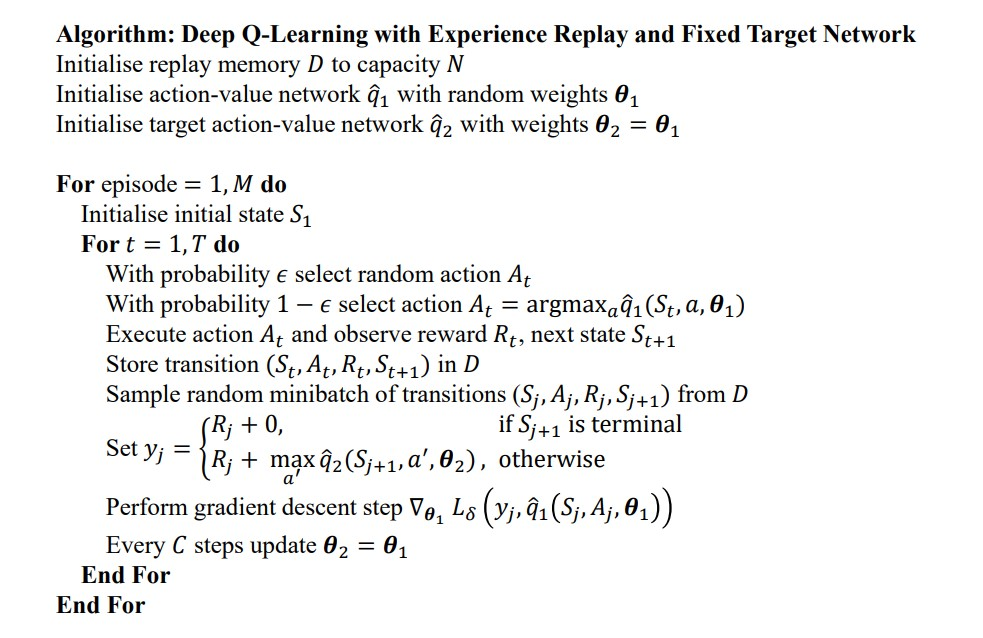

###Version 1

* Implementation of the above algorithim provided in the lectures.
* Neural network which takes the state action inputs and produces a single output which represents the value of the state. 
* Algorithm is very slow because it has to run a prediction on every single available action.



In [ ]:
import tensorflow as tf
from tensorflow.python.keras import Sequential, Model
from tensorflow.python.keras.layers import Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import numpy as np
import copy

class DQLearning_Agent_with_ER_and_FTN_V1:
  def __init__(self):
    # Parameters
    self.epsilon = 0.1
    self.alpha = 0.2
    self.d_min = 10
    self.d_max = 1000
    self.c = 15

    self.env = bd.SudokuTetrisGame()
    self.state_action_representation_length = len(self.state_action_representation(self.env.board, self.env.current_pieces, 0)[0])
    ## Algorithm: Deep Q-Learning with Experience Replay and Fixed Target Network
    ## Initialise replay memory 𝐷 to capacity 𝑁
    self.d = []
    ## Initialise action-value network 𝑞1 with random weights 𝜽1
    self.q1 = self._build_DNN()
    ## Initialise target action-value network 𝑞2 with weights 𝜽2 = 𝜽1
    self.q2 = tf.keras.models.clone_model(self.q1)

  def train(self, episodes=1):
    step_count = 1
    ## For episode = 1, 𝑀 do
    for e in range(episodes):
      ## Initialise initial state 𝑆1
      self.env.reset()
      state = copy.deepcopy(self.env)
      ## For 𝑡 = 1, 𝑇 do
      done = False
      total_reward = 0
      while not done:
        ## With probability 𝜖 select random action 𝐴𝑡
        if self.epsilon > random.random():
          # random action
          action = self.env.sample_action()
        ## With probability 1 − 𝜖 select action 𝐴𝑡 = argmax𝑎𝑞1(𝑆𝑡, 𝑎, 𝜽1)
        else:
          # greedy action
          best_action = None
          best_value = - float('inf')
          for a in self.env.get_available_actions():
            v = self.q1.predict(self.state_action_representation(self.env.board, self.env.current_pieces, a))[0][0]
            if v > best_value:
              best_action = a
              best_value = v
          action = best_action
        ## Execute action 𝐴𝑡 and observe reward 𝑅𝑡, next state 𝑆𝑡+1
        _, reward, done, _ = self.env.step(action)
        total_reward += reward
        # print("Reward:", reward)
        ## Store transition (𝑆𝑡, 𝐴𝑡, 𝑅𝑡, 𝑆𝑡+1) in 𝐷
        next_state = copy.deepcopy(self.env)
        self.store_in_d((state, action, reward, next_state))
        ## Sample random minibatch of transitions (𝑆𝑗, 𝐴𝑗, 𝑅𝑗, 𝑆𝑗+1) from 𝐷
        if len(self.d) > self.d_min:
          for i in range(5):
            state, action, reward, next_state = random.choice(self.d)
            ## if 𝑆𝑗+1 is terminal: Set 𝑦𝑗 = 𝑅𝑗 + 0
            if next_state.check_if_done():
              yj = reward
            ## otherwise:           Set 𝑦𝑗 = 𝑅𝑗 + max 𝑎′𝑞2(𝑆𝑗+1, 𝑎′, 𝜽2)
            else:
              best_value = max([self.q2.predict(self.state_action_representation(next_state.board, next_state.current_pieces, a))[0][0] for a in next_state.get_available_actions()])
              yj = reward + best_value
            ## Perform gradient descent step ∇𝜽1𝐿𝛿(𝑦𝑗, 𝑞1(𝑆𝑗, 𝐴𝑗, 𝜽1))
            self.q1.fit(self.state_action_representation(state.board, state.current_pieces, action), np.array(yj).reshape(-1,1), epochs=1, verbose=False)
        ## Every 𝐶 steps update 𝜽2 = 𝜽1
        if step_count % self.c == 0:
          self.q2 = tf.keras.models.clone_model(self.q1)
        # update variables
        step_count += 1
        state = next_state
      ## End For
      print("Total reward:", total_reward)
    ## End For

  def _build_DNN(self):
    model = Sequential()
    inputs_length = self.state_action_representation_length
    input_shape = (inputs_length,)
    model.add(Input(shape=input_shape))
    model.add(Dense(20, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(20, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='linear', kernel_initializer='he_uniform'))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=Adam(lr=self.alpha))
    return model

  def state_action_representation(self, board, pieces, action):
    # Get state representation
    board_rep = []
    for x in range(len(board)):
      for y in range(len(board)):
        if board[x][y]:
          board_rep.append(1)
        else:
          board_rep.append(0)
    pieces_rep = [1 if bd.PIECES[x] in pieces else 0 for x in range(len(bd.PIECES))]
    state_rep = board_rep + pieces_rep
    # Get action represetation
    action_range = range(0 * np.prod(self.env.board_size), ((len(bd.PIECES) - 1) + 1) * np.prod(self.env.board_size))
    action_rep = [1 if x == action else 0 for x in action_range]
    return np.array([state_rep + action_rep]).reshape(-1, len(state_rep + action_rep))
  
  def store_in_d(self, result):
    if len(self.d) < self.d_max:
      self.d.append(result)
    else:
      self.d = self.d[1:] + [result]


In [ ]:
agent = DQLearning_Agent_with_ER_and_FTN_V1()
agent.train(1000)

KeyboardInterrupt: ignored

###Version 2

Changes from DQNAgent_with_ER_and_FTN_V1:
* Replay function runs keras.model.fit  on a vector of all states instead of individually for each state for faster updates
* Neural Network takes only state of the board as an input (optionally can take board + current_pieces)
  * State now represented as a one-hot encoding, where each available square/piece is either a 1 (True) or 0
  * Input can either be run as piece-agnostic (finding all the q-values and then choosing the max on the basis of availability) or with pieces as part of state representation - Change parameter/argument state_includes_pieces to toggle
* Algorithm now runs epsilon decay once memory is full, to use an increasingly greedy/non-random strategy over time
* Outputs a plot of the reward over episodes as well as information about the current episode after finishing episode and updates (turn on/off with parameter verbose=2 for plot, =1 for episode state, 0 for nothing)
* Added gamma and inverse_gamma parameters, for testing the effect of discounting long-term rewards (gamma < 1) or short-term rewards (inverse_gamma < 1)
* Automatically saves a plot of the reward per episode to the files section (filenmame DQN_V2_output-{current datetime}.png)


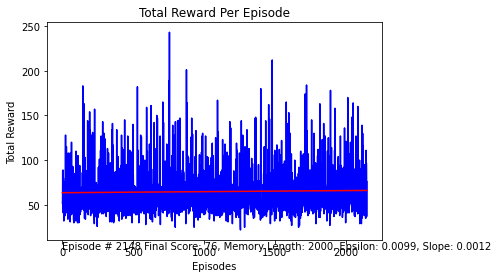

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import Sequential, Model
from tensorflow.python.keras.layers import Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import numpy as np
import copy
import pylab as plt
from google.colab import output
import os.path
from datetime import datetime

class DQNAgent_with_ER_and_FTN_V2:
  def __init__(self, verbose=2, state_includes_pieces=False, use_toy_env=False):
    # Parameters
    self.epsilon = 0.99
    self.epsilon_decay = .99
    self.epsilon_min = .01
    self.alpha = 0.15
    self.gamma = 1
    self.inverse_gamma = 1
    self.d_min = 1000
    self.d_max = 2000
    self.c = 20
    self.no_replays = 10

    #Adjustable Parameters
    self.verbose=verbose
    self.start_time = datetime.now()
    self.state_includes_pieces = state_includes_pieces;

    self.env = bdtoy.SudokuTetrisGame() if use_toy_env else bd.SudokuTetrisGame()
    
    self.input_shape = (self.state_action_representation(self.env).size,)
    
    ## Algorithm: Deep Q-Learning with Experience Replay and Fixed Target Network
    ## Initialise replay memory 𝐷 to capacity 𝑁
    self.d = deque(maxlen = self.d_max)
    ## Initialise action-value network 𝑞1 with random weights 𝜽1
    self.q1 = self._build_DNN()
    ## Initialise target action-value network 𝑞2 with weights 𝜽2 = 𝜽1
    self.q2 = tf.keras.models.clone_model(self.q1)

  def train(self, episodes=1):
    scores, eps = [], []
    step_count = 1
    ## For episode = 1, 𝑀 do
    for e in range(episodes):
      ## Initialise initial state 𝑆1
      self.env.reset()
      state = copy.deepcopy(self.env)
      ## For 𝑡 = 1, 𝑇 do
      done = False
      total_reward = 0
      while not done:
        ## With probability 𝜖 select random action 𝐴𝑡
        action = self.get_epsilon_greedy_action()
        ## Execute action 𝐴𝑡 and observe reward 𝑅𝑡, next state 𝑆𝑡+1
        _, reward, done, _ = self.env.step(action)
        total_reward += reward
        ## Store transition (𝑆𝑡, 𝐴𝑡, 𝑅𝑡, 𝑆𝑡+1) in 𝐷
        next_state = copy.deepcopy(self.env)
        self.d.append((state, action, reward, next_state))

        ## Sample random minibatch of transitions (𝑆𝑗, 𝐴𝑗, 𝑅𝑗, 𝑆𝑗+1) from 𝐷
        if len(self.d) > self.d_min:
          self.replay(self.no_replays)
          
        ## Every 𝐶 steps update 𝜽2 = 𝜽1
        if step_count % self.c == 0:
          self.q2 = tf.keras.models.clone_model(self.q1)
        # update variables
        step_count += 1
        state = next_state

        if done:
          ## Decay epsilon after each episode (not in original algorithm) (only if memory full)
          if self.epsilon > self.epsilon_min and len(self.d) > self.d_min:
            self.epsilon *= self.epsilon_decay

          # every episode, plot the play time
          eps.append(e+1)
          scores.append(total_reward)
          self.plot_print_and_write_to_file(eps, scores)
          
      ## End For
    ## End For

  def plot_print_and_write_to_file(self, eps, scores):
    # Plot
    x, y =  np.array(eps), np.array(scores)
    
    plt.plot(x, y, 'b')
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color='red')
    plt.title('Total Reward Per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')

    # Print
    if self.verbose >= 1:
      plt_text = "Episode # {} Final Score: {}, Memory Length: {}, Epsilon: {:.4f}, Slope: {:.4f}".format(eps[-1], scores[-1], len(self.d), self.epsilon, m)
      plt.text(.5, .05, plt_text)

    # Write to file
    current_time = self.start_time.strftime("%a_%d%B%Y-%H:%M:%S")
    fname = "DQN_V2_output-" + current_time + ".png"
    plt.savefig('/content/{}'.format(fname))

    if self.verbose == 2:
      # Show plot
      output.clear()
      plt.show()
    
  def get_epsilon_greedy_action(self):
    # Get Random Action
    if self.epsilon > random.random():
      return self.env.sample_action()
    ## Greedy Action: With probability 1 − 𝜖 select action 𝐴𝑡 = argmax𝑎𝑞1(𝑆𝑡, 𝑎, 𝜽1)
    else:
      prediction = self.predict_q1(self.env).flatten()
      return np.nanargmax(prediction)

  def replay(self, no_replays):
    for i in range(no_replays):
      state, action, reward, next_state = random.choice(self.d)
      yj = np.zeros(2025)
      ## if 𝑆𝑗+1 is terminal: Set 𝑦𝑗 = 𝑅𝑗 + 0
      if next_state.check_if_done():
        yj[action] = self.inverse_gamma*reward
      ## otherwise: Set 𝑦𝑗 = 𝑅𝑗 + max 𝑎′𝑞2(𝑆𝑗+1, 𝑎′, 𝜽2)
      else:
        prediction = self.predict_q2(next_state).flatten()
        best_action = np.nanargmax(prediction)
        best_value = prediction[best_action]
        yj[action] = self.inverse_gamma*reward + self.gamma*best_value

      ## Perform gradient descent step ∇𝜽1𝐿𝛿(𝑦𝑗, 𝑞1(𝑆𝑗, 𝐴𝑗, 𝜽1))
      self.q1.fit(self.state_action_representation(state), yj.reshape(1, -1), epochs=1, verbose=False)

  def _build_DNN(self):
    model = Sequential()
    model.add(Input(shape=self.input_shape))
    model.add(Dense(20, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(20, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(2025, activation='linear', kernel_initializer='he_uniform'))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=Adam(lr=self.alpha))
    return model

  def predict_q1(self, state) :
    DNN_input = self.state_action_representation(state)
    prediction = self.q1.predict(DNN_input)
    available_actions = self.env.get_available_actions(True)
    aa_actions = np.where(available_actions==0, np.nan, available_actions)
    available_prediction = np.multiply(prediction, aa_actions)
    # for i in range(25):
      #   print("1", available_actions[i*81: (i+1)*81])
      #   print("2", aa_actions[i*81: (i+1)*81])
        # print("3", prediction[i*81: (i+1)*81])
      # print(np.nanargmax(available_prediction))
    return available_prediction

  def predict_q2(self, state):
    DNN_input = self.state_action_representation(state)
    prediction = self.q2.predict(DNN_input)
    available_actions = state.get_available_actions(True)
    aa_actions = np.where(available_actions==0, np.nan, available_actions)
    available_prediction = np.multiply(prediction, aa_actions)
    return available_prediction

  def state_action_representation(self, state):
    # Get state representation
    board_rep = [1 if square else 0 for square in state.board.flatten()]
    # Change parameter to include the pieces in the state representation (Optional)
    if self.state_includes_pieces:
      pieces_rep = [1 if bd.PIECES[x] in state.current_pieces else 0 for x in range(len(bd.PIECES))]
      board_rep = board_rep + pieces_rep

    return np.array(board_rep).reshape(-1, len(board_rep))

agent = DQNAgent_with_ER_and_FTN_V2()
agent.train(10000)

###Version 3

NN changed to: State -> Value 

adapted from DQNAgent_with_ER_and_FTN_V2:

(Some of the algorithm comments with ## are no longer accurate)

- Outputs a csv data file with data from each episode: episode_no, final_score, memory_length, epsilon, slope


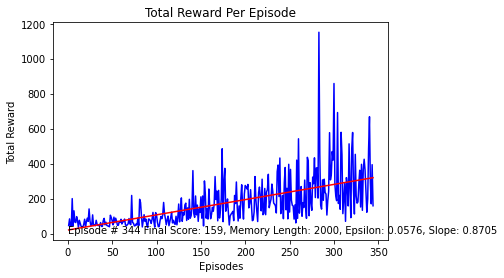

KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import Sequential, Model
from tensorflow.python.keras.layers import Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import numpy as np
import copy
import pylab as plt
from google.colab import output
import os.path
from datetime import datetime

class DQNAgent_with_ER_and_FTN_V3:
  def __init__(self, verbose=2, state_includes_pieces=False, use_toy_env=False, clone=None):
    # Parameters
    self.epsilon = 0.99
    self.epsilon_decay = .99
    self.epsilon_min = .01
    self.alpha = 0.15
    self.gamma = 1
    self.inverse_gamma = 1
    self.d_min = 1000
    self.d_max = 2000
    self.c = 20
    self.no_replays = 10

    #Adjustable Parameters
    self.verbose=verbose
    self.start_time = datetime.now()
    self.state_includes_pieces = state_includes_pieces;

    self.env = bdtoy.SudokuTetrisGame() if use_toy_env else bd.SudokuTetrisGame()
    
    self.input_shape = (self.state_action_representation(self.env).size,)
    
    ## Algorithm: Deep Q-Learning with Experience Replay and Fixed Target Network
    ## Initialise replay memory 𝐷 to capacity 𝑁
    self.d = deque(maxlen = self.d_max)
    ## Initialise action-value network 𝑞1 with random weights 𝜽1
    self.q1 = self._build_DNN()
    ## Initialise target action-value network 𝑞2 with weights 𝜽2 = 𝜽1
    self.q2 = tf.keras.models.clone_model(self.q1)

    if clone != None:
      self.start_time = clone.start_time
      self.d = clone.d
      self.q1 = clone.q1
      self.q2 = clone.q2

  def train(self, episodes=1):
    scores, eps = [], []
    step_count = 1
    ## For episode = 1, 𝑀 do
    for e in range(episodes):
      ## Initialise initial state 𝑆1
      self.env.reset()
      state = copy.deepcopy(self.env)
      ## For 𝑡 = 1, 𝑇 do
      done = False
      total_reward = 0
      while not done:
        ## With probability 𝜖 select random action 𝐴𝑡
        action = self.get_epsilon_greedy_action()
        ## Execute action 𝐴𝑡 and observe reward 𝑅𝑡, next state 𝑆𝑡+1
        _, reward, done, _ = self.env.step(action)
        total_reward += reward
        ## Store transition (𝑆𝑡, 𝐴𝑡, 𝑅𝑡, 𝑆𝑡+1) in 𝐷
        next_state = copy.deepcopy(self.env)
        self.d.append((state, action, reward, next_state))

        ## Sample random minibatch of transitions (𝑆𝑗, 𝐴𝑗, 𝑅𝑗, 𝑆𝑗+1) from 𝐷
        if len(self.d) > self.d_min:
          self.replay(self.no_replays)
          
        ## Every 𝐶 steps update 𝜽2 = 𝜽1
        if step_count % self.c == 0:
          self.q2 = tf.keras.models.clone_model(self.q1)
        # update variables
        step_count += 1
        state = next_state

        
        if done:
          ## Decay epsilon after each episode (not in original algorithm) (only if memory full)
          if self.epsilon > self.epsilon_min and len(self.d) > self.d_min:
            self.epsilon *= self.epsilon_decay

          # every episode, plot the play time
          eps.append(e+1)
          scores.append(total_reward)
          
          self.plot_print_and_write_to_file(eps, scores)
          
      ## End For
    ## End For

  def plot_print_and_write_to_file(self, eps, scores):
    # Plot
    x, y =  np.array(eps), np.array(scores)
    
    plt.plot(x, y, 'b')
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color='red')
    plt.title('Total Reward Per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')

    # Print
    if self.verbose >= 1:
      plt_text = "Episode # {} Final Score: {}, Memory Length: {}, Epsilon: {:.4f}, Slope: {:.4f}".format(eps[-1], scores[-1], len(self.d), self.epsilon, m)
      plt.text(.5, .05, plt_text)

    # Write graph to file "DQN_V3_output{datetime}.png"
    current_time = self.start_time.strftime("%a_%d%B%Y-%H:%M:%S")
    png_fname = "DQN_V3_output-" + current_time + ".png"
    plt.savefig('/content/{}'.format(png_fname))

    # Save data to a csv-formatted file
    csv_fname = "'DQN_V3_data-" + current_time + ".csv"
    if not os.path.exists(csv_fname):
      with open(csv_fname, 'w+') as f:
        title = "episode_no,final_score,memory_length,epsilon,slope\n"
        f.write(title)

    with open(csv_fname, 'a') as f:
      data = "{},{},{},{},{}\n".format(eps[-1], scores[-1], len(self.d), self.epsilon, m)
      f.write(data)

    # # Save q1 and q2 to files (Use if Pickle doesn't work, otherwise delete)
    # q1_model_fname = "'DQN_V3_q1_model-" + current_time
    # tf.keras.models.save_model(self.q1, q1_model_fname, overwrite=True)
    # q2_model_fname = "'DQN_V3_q2_model-" + current_time
    # tf.keras.models.save_model(self.q1, q2_model_fname, overwrite=True)

    if self.verbose == 2:
      # Show plot
      output.clear()
      plt.show()

  def get_greedy_action(self):
    best_action = None
    best_value = - float('inf')
    for a in self.env.get_available_actions():
      env_copy = copy.deepcopy(self.env)
      _, reward, done, _ = env_copy.step(a)
      if not done:
        v = reward + self.q1.predict(self.state_action_representation(env_copy))[0][0]
      else:
        v = reward
      if v > best_value:
        best_action = a
        best_value = v
    action = best_action
    return action

    def get_greedy_action2(self):
    done_arr, reward_arr, state_arr = [], [], []
    action_arr = self.env.get_available_actions()
    for a in action_arr:
      env_copy = copy.deepcopy(self.env)
      _, reward, done, _ = env_copy.step(a)
      done_arr.append(0 if done else 1)
      reward_arr.append(reward)
      state_arr.append(self.state_action_representation(env_copy))
    done_arr, reward_arr, state_arr = np.array(done_arr), np.array(reward_arr), np.array(state_arr)
    # Run predict on a batch of all possible states for action
    next_value_arr = np.reshape(self.q1.predict(np.array(state_arr)), reward_arr.shape)
    # v = r + (v_next_state if done else 0)
    v_arr = np.add(np.array(reward_arr), np.multiply(np.array(done_arr), next_value_arr))
    # Choose best action from v then find corresponding action
    action = action_arr[np.argmax(v_arr)]
    return action
    
  def get_epsilon_greedy_action(self):
    # Get Random Action
    if self.epsilon > random.random():
      return self.env.sample_action()
    ## Greedy Action: With probability 1 − 𝜖
    else:
      # return self.get_greedy_action2()
      return self.get_greedy_action()

  def replay(self, no_replays):
      for i in range(no_replays):
        state, action, reward, next_state = random.choice(self.d)
        yj = 0
        ## if 𝑆𝑗+1 is terminal: Set 𝑦𝑗 = 𝑅𝑗 + 0
        if next_state.check_if_done():
          yj = reward        
        ## otherwise: Set 𝑦𝑗 = 𝑅𝑗 + max 𝑎′𝑞2(𝑆𝑗+1, 𝑎′, 𝜽2)
        else:
          # prediction = self.predict_q2(next_state).flatten()
          # best_action = np.nanargmax(prediction)
          # best_value = prediction[best_action]
          # yj[action] = self.inverse_gamma*reward + self.gamma*best_value
          yj = reward + self.predict_q2(next_state)[0][0]
        ## Perform gradient descent step ∇𝜽1𝐿𝛿(𝑦𝑗, 𝑞1(𝑆𝑗, 𝐴𝑗, 𝜽1))
        self.q1.fit(self.state_action_representation(state), np.array([yj]).reshape(1, -1), epochs=1, verbose=False)

  def _build_DNN(self):
    model = Sequential()
    model.add(Input(shape=self.input_shape))
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='linear', kernel_initializer='he_uniform'))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=Adam(lr=self.alpha))
    return model

  def predict_q1(self, state) :
    DNN_input = self.state_action_representation(state)
    value_prediction = self.q1.predict(DNN_input)
    return value_prediction

  def predict_q2(self, state):
    DNN_input = self.state_action_representation(state)
    value_prediction = self.q2.predict(DNN_input)
    return value_prediction

  def state_action_representation(self, state):
    # Get state representation
    board_rep = [1 if square else 0 for square in state.board.flatten()]
    # Change parameter to include the pieces in the state representation (Optional)
    if self.state_includes_pieces:
      pieces_rep = [1 if bd.PIECES[x] in state.current_pieces else 0 for x in range(len(bd.PIECES))]
      board_rep = board_rep + pieces_rep

    return np.array(board_rep).reshape(-1, len(board_rep))

agent = DQNAgent_with_ER_and_FTN_V3()
agent.train(10000)

In [ ]:
# In case the above times out
agent2 = DQNAgent_with_ER_and_FTN_V3(clone=agent)
agent2.train(10000)

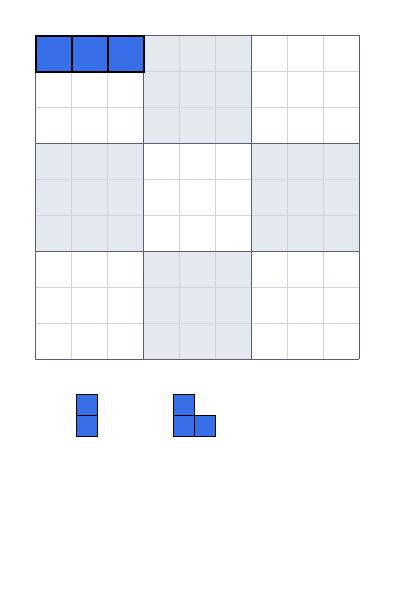

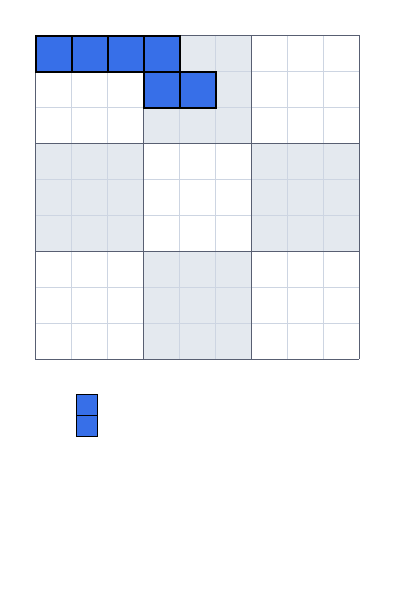

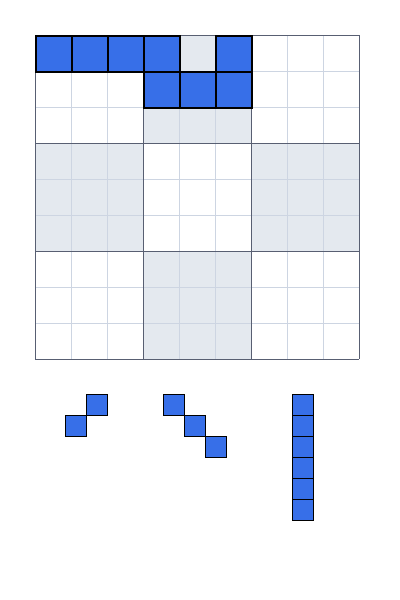

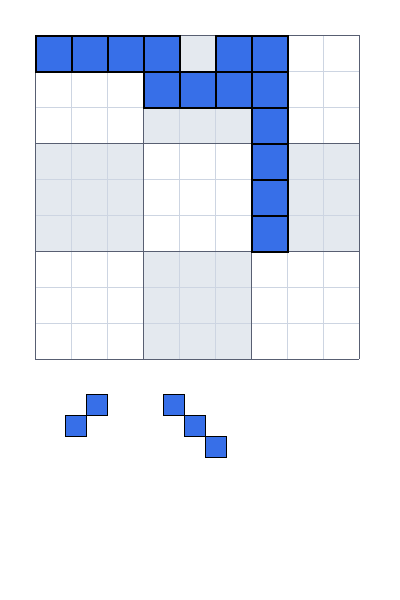

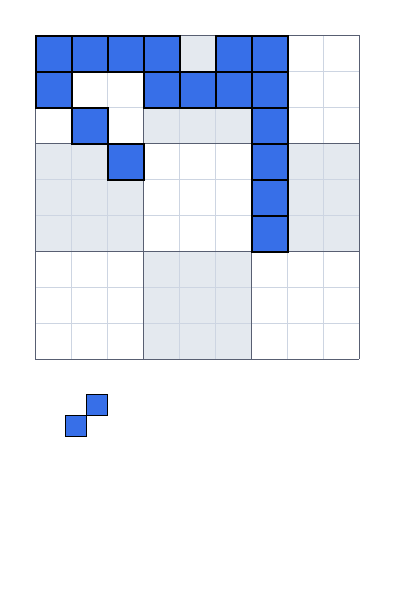

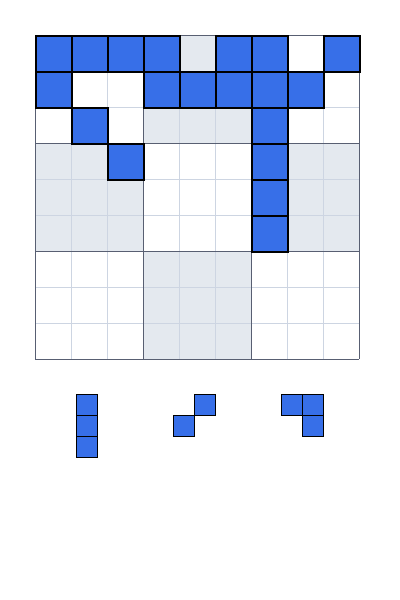

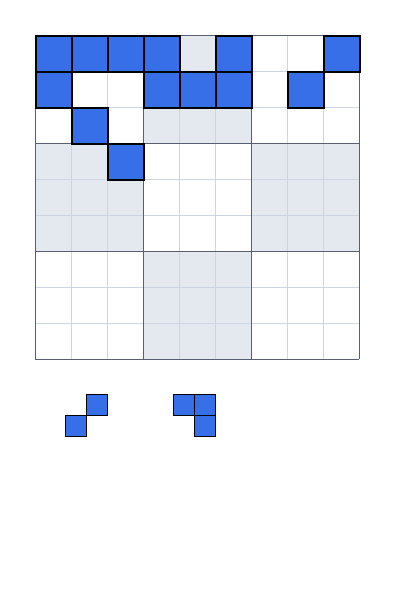

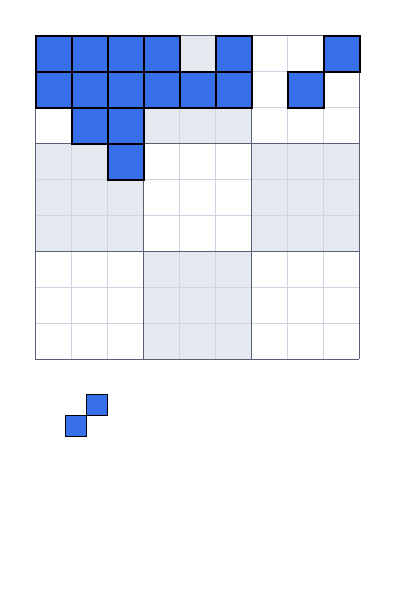

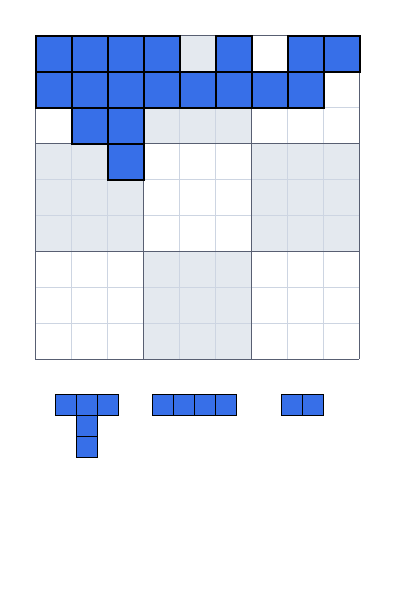

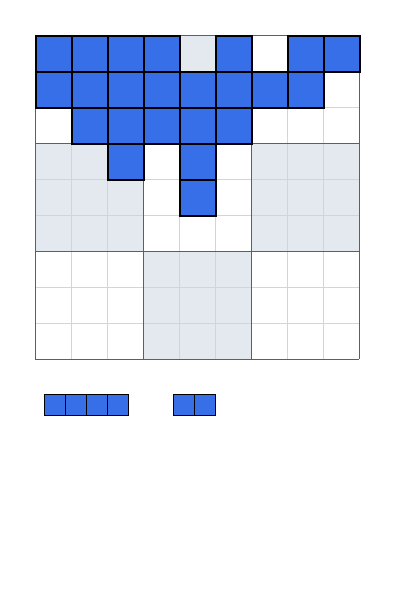

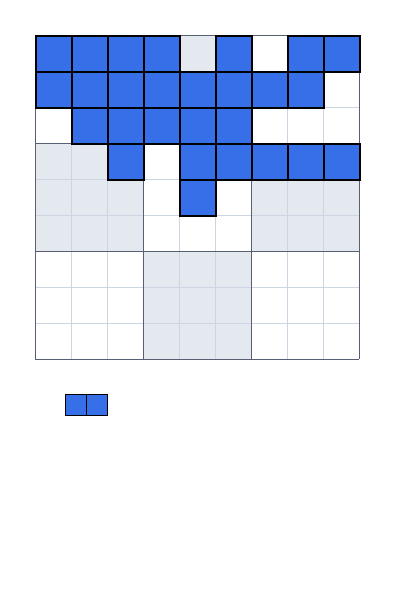

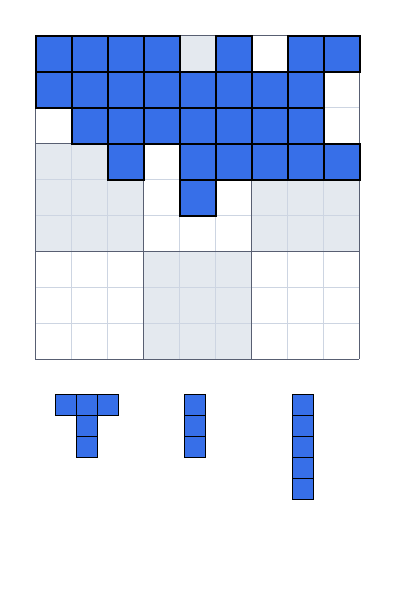

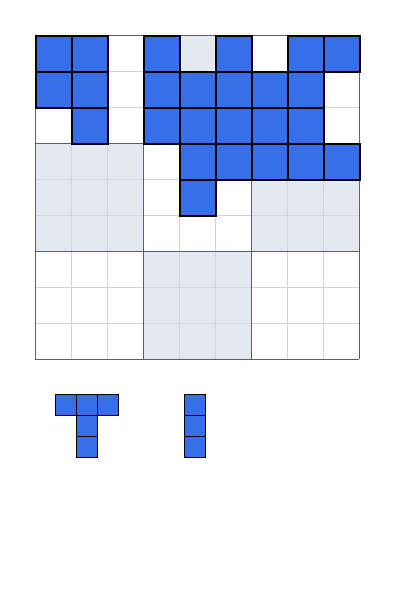

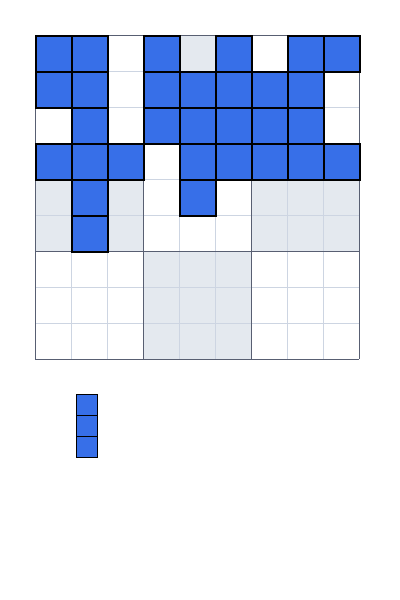

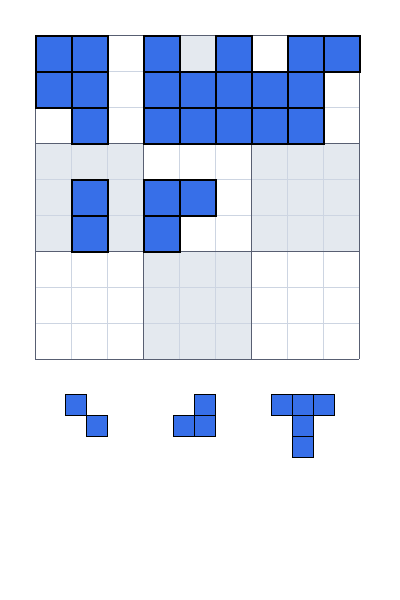

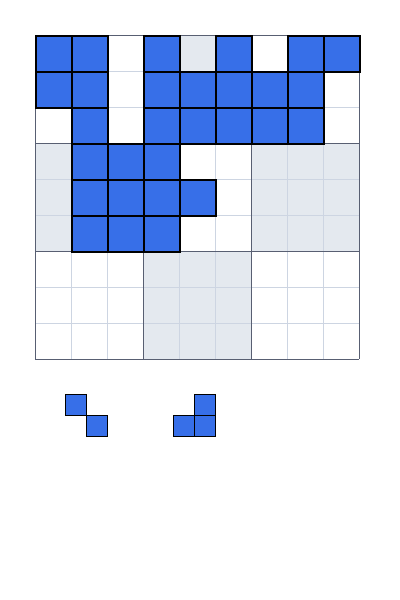

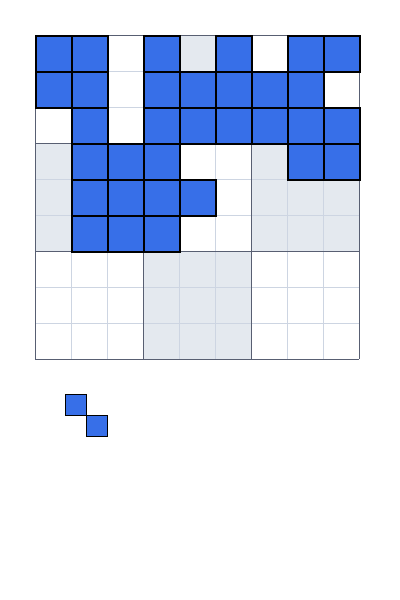

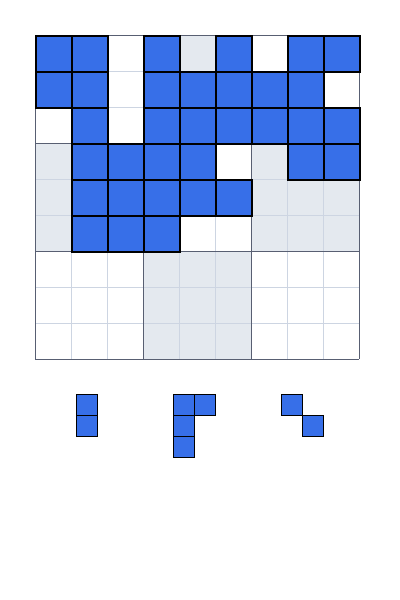

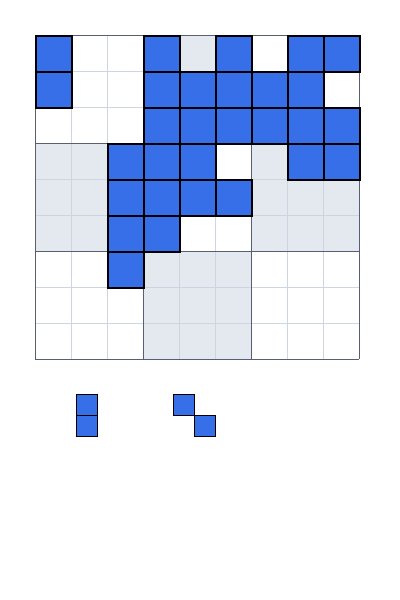

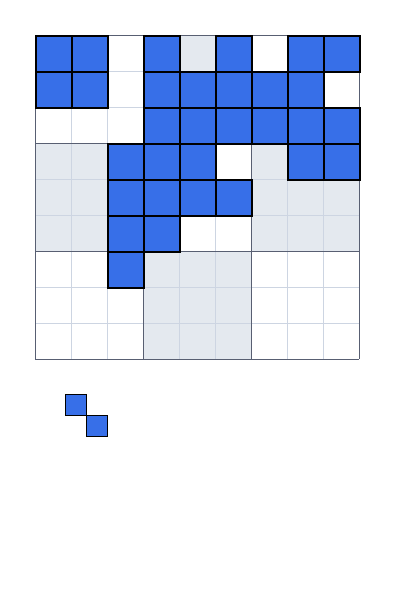

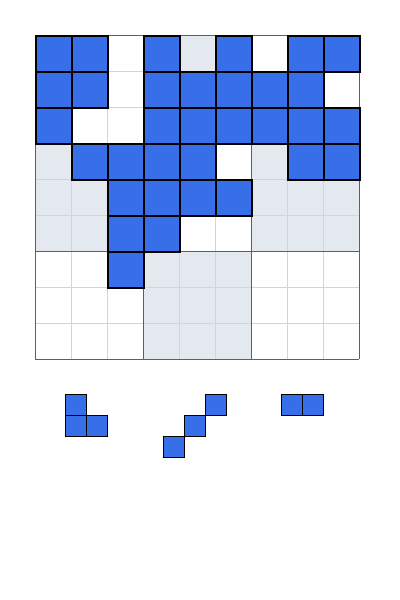

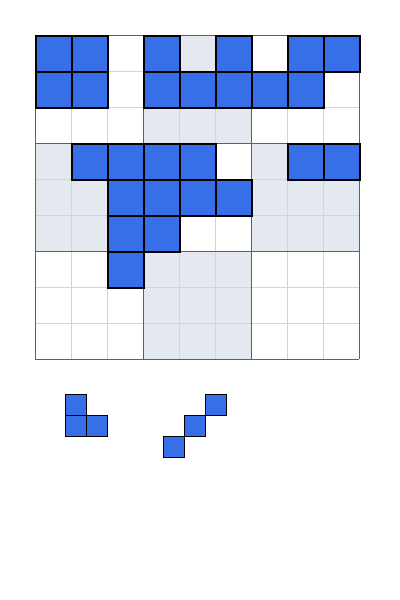

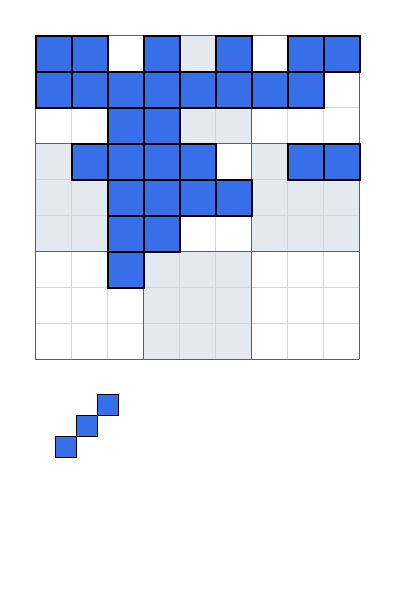

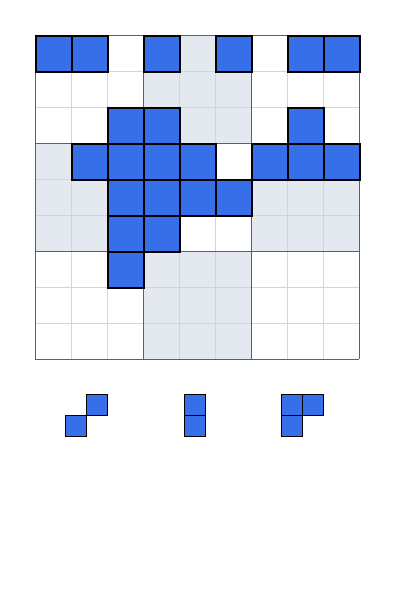

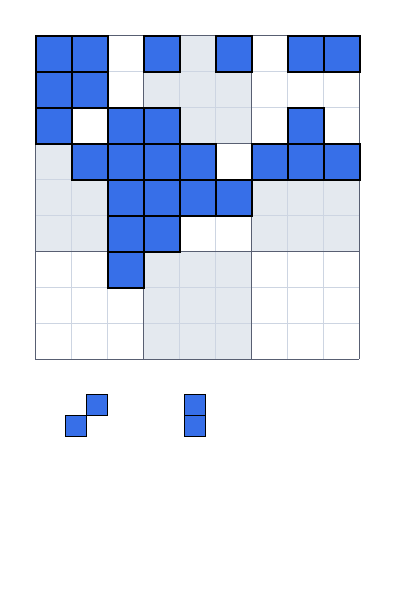

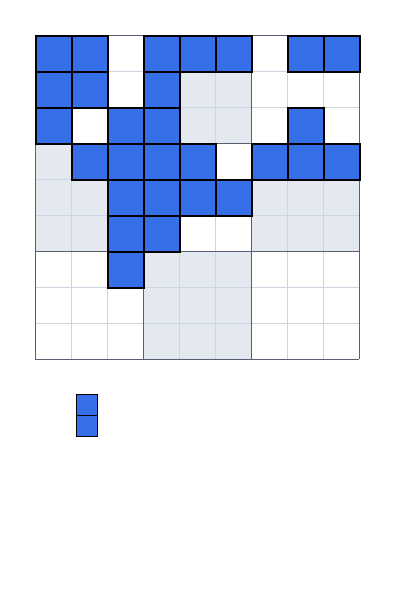

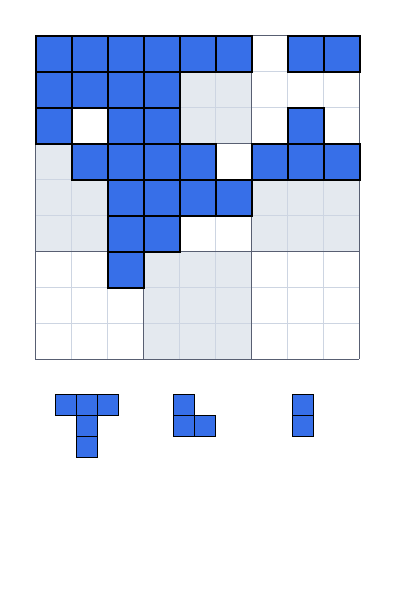

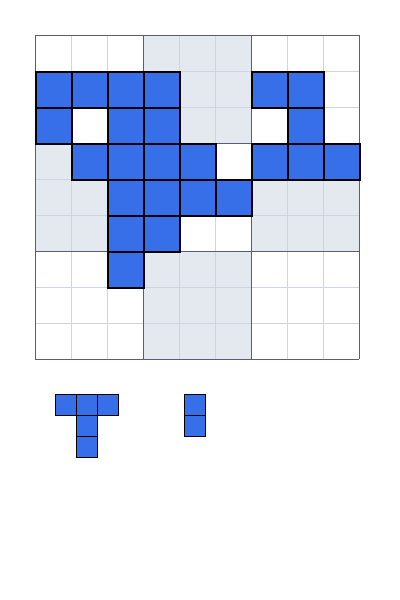

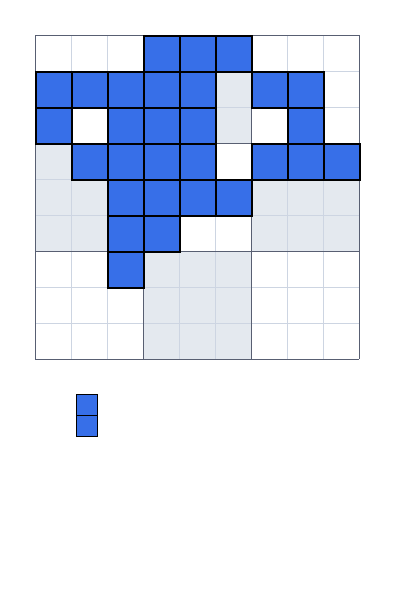

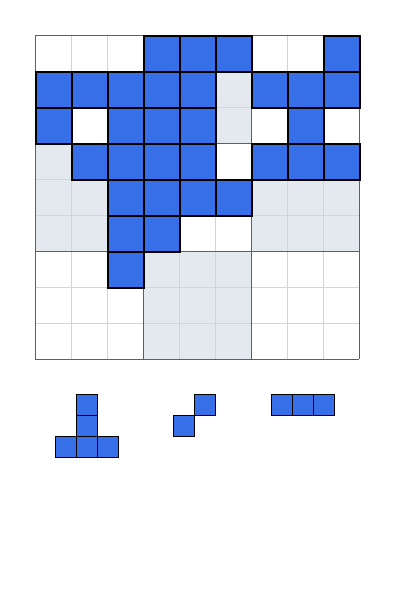

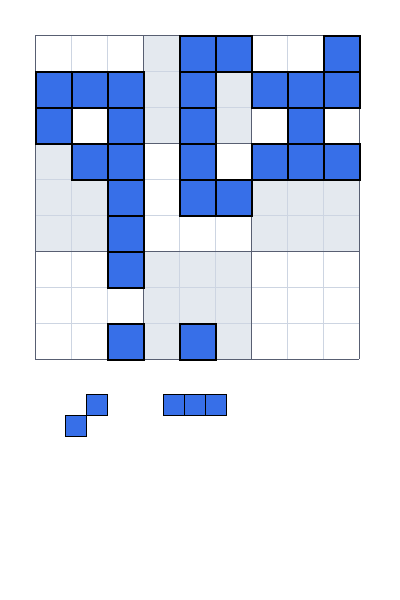

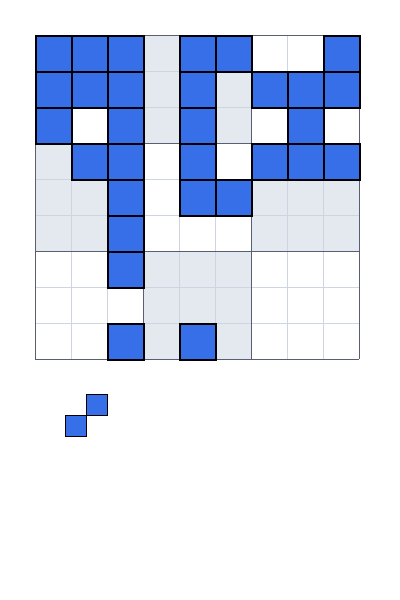

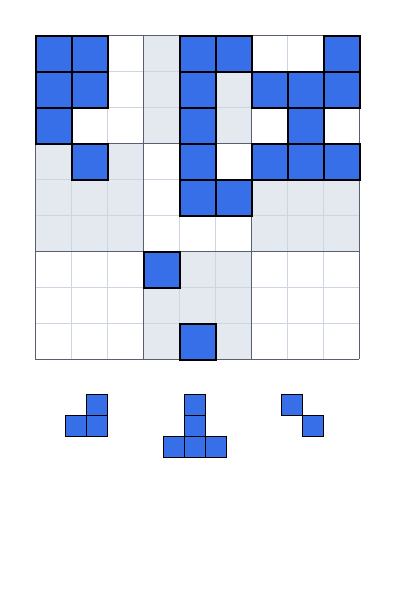

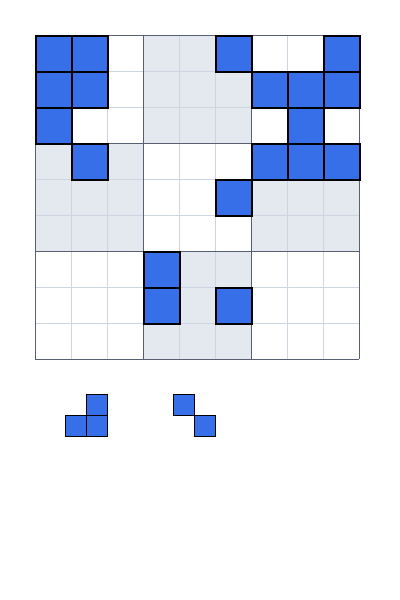

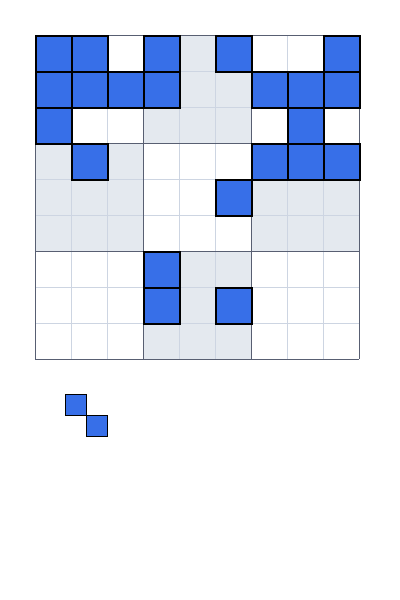

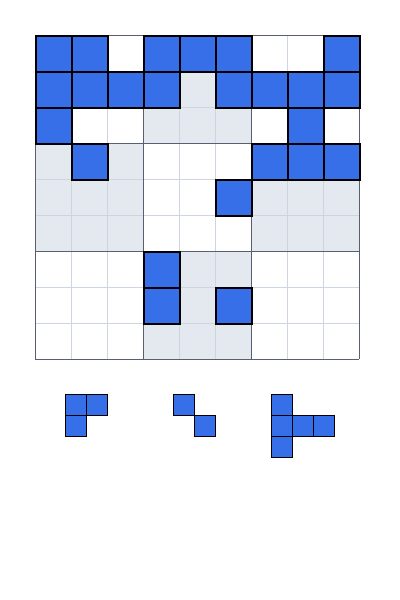

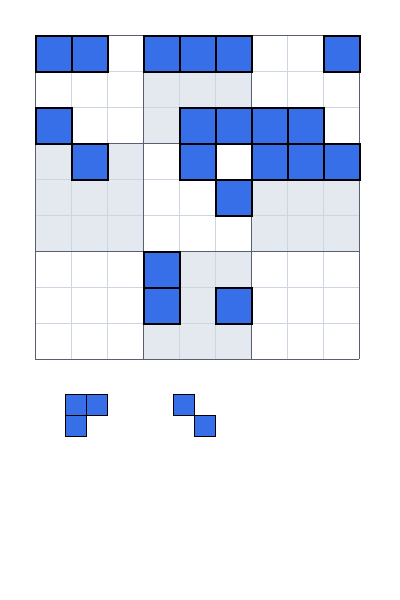

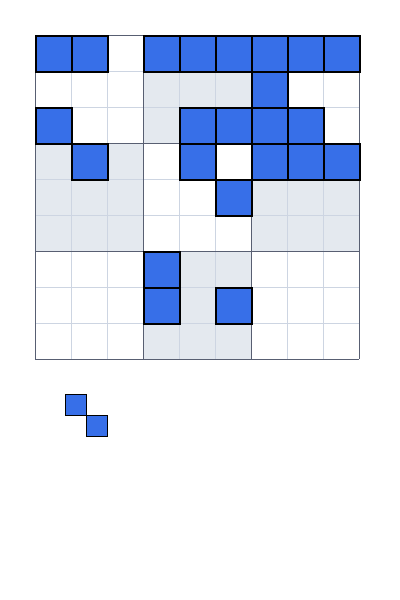

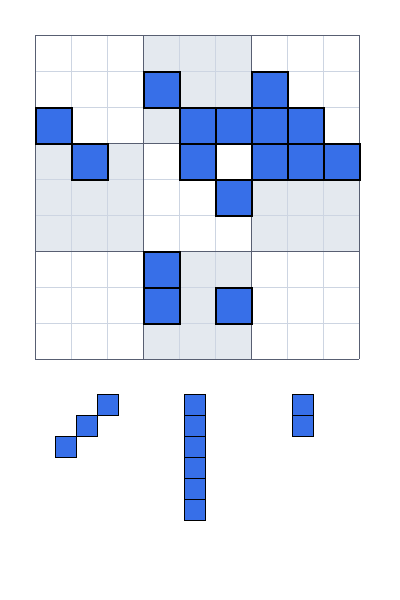

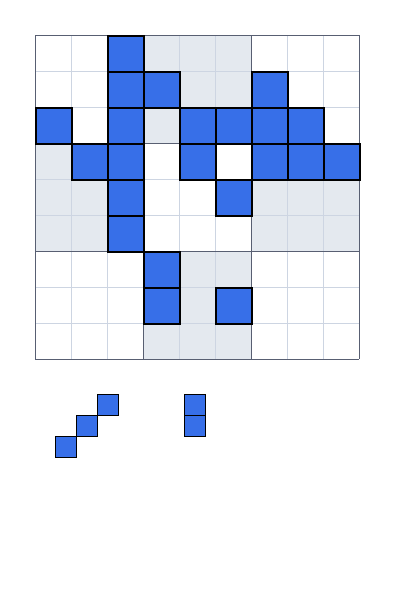

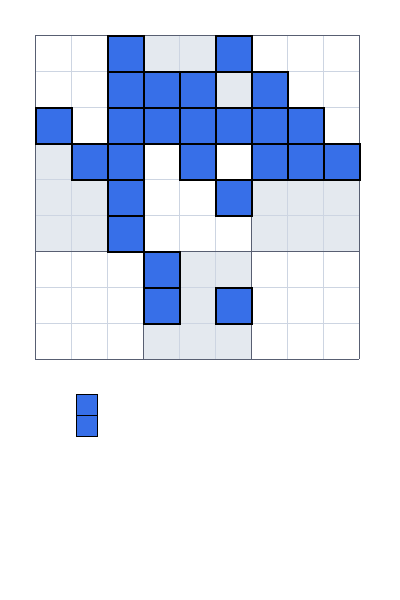

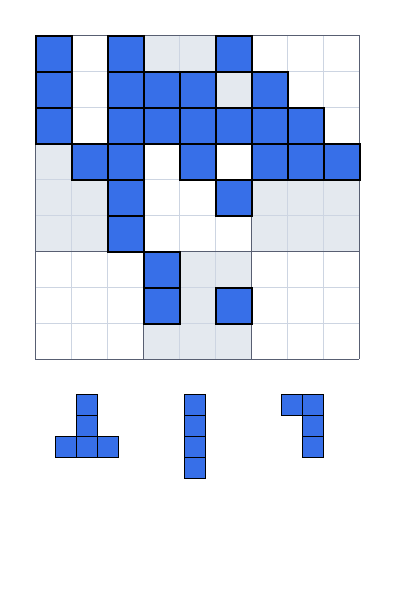

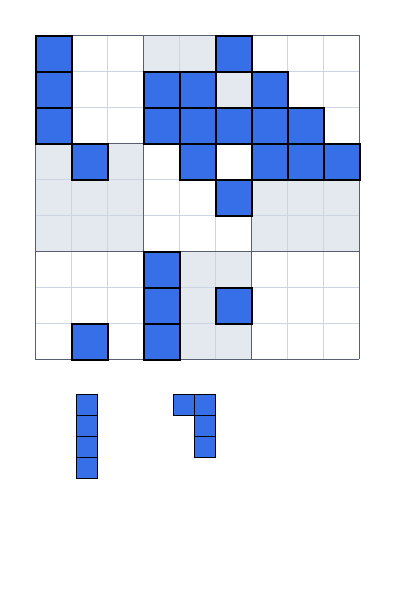

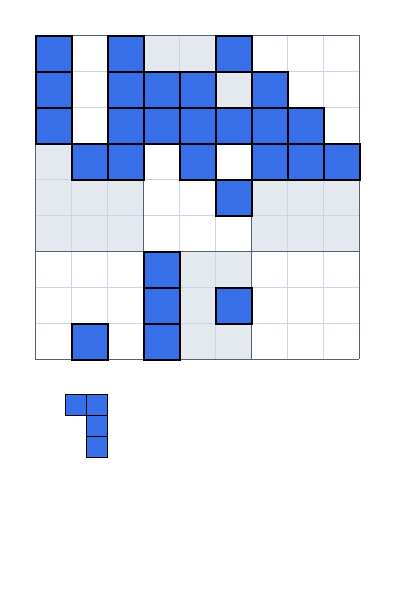

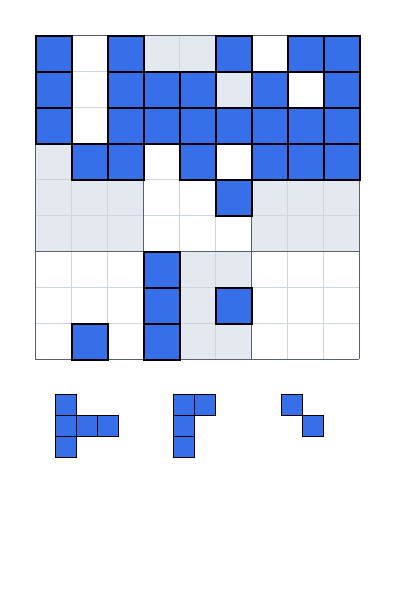

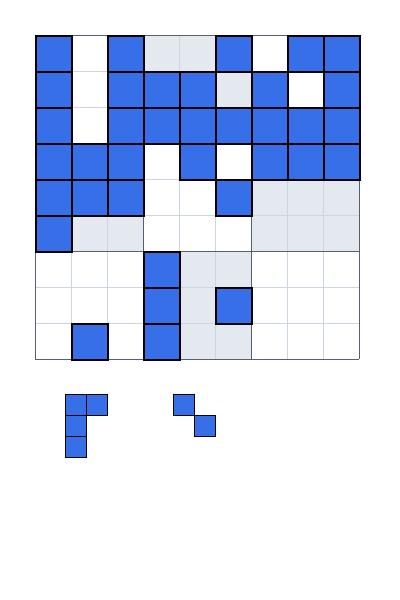

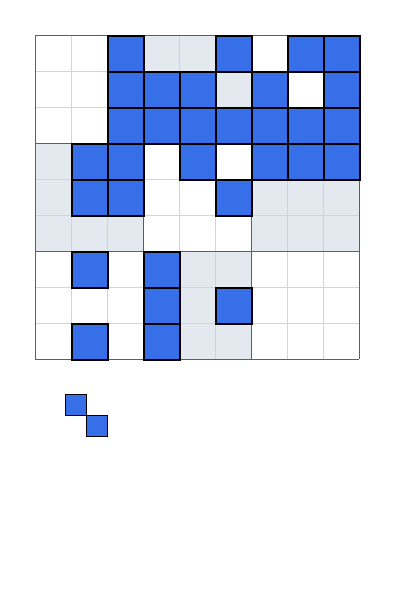

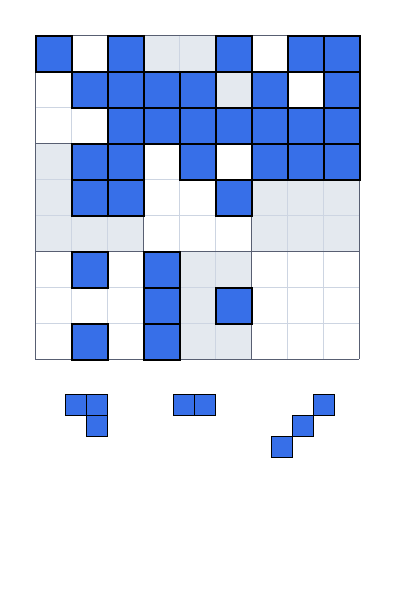

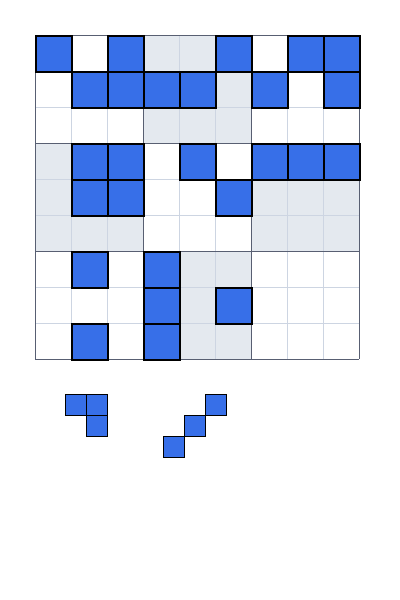

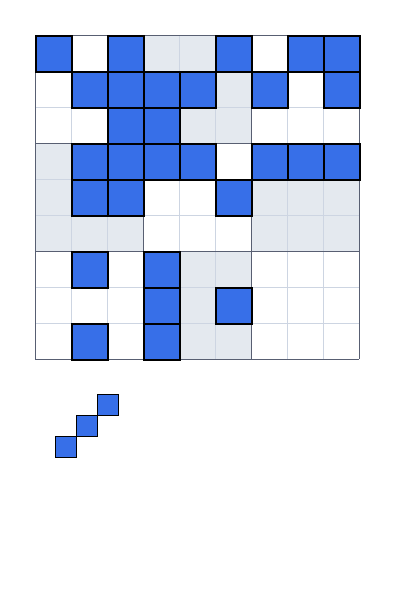

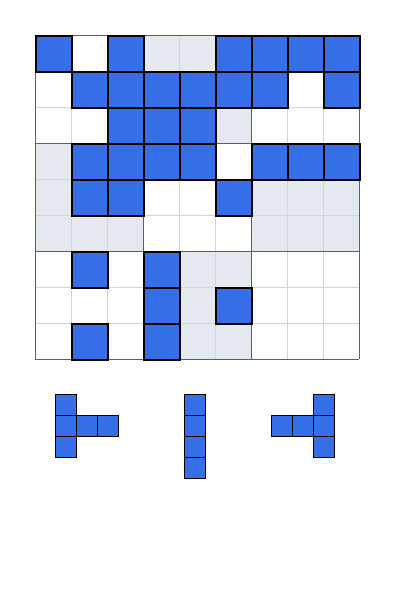

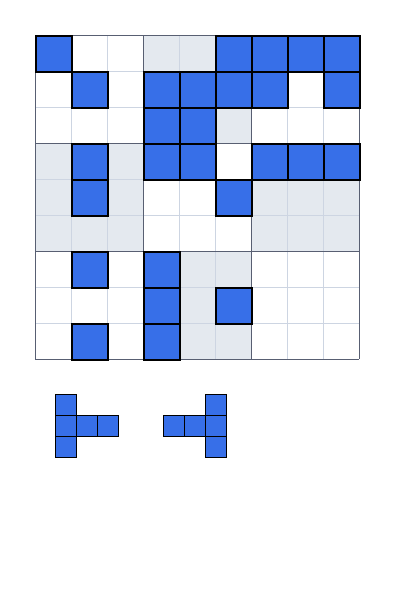

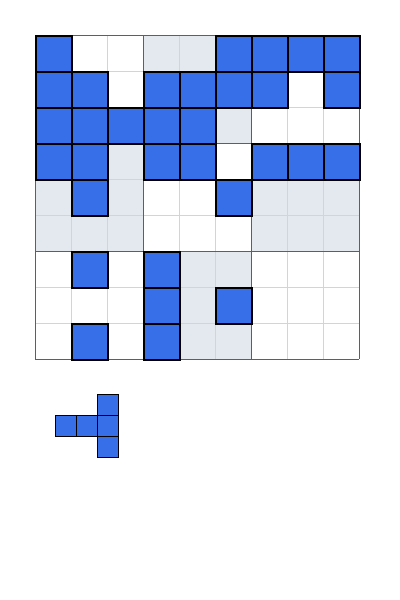

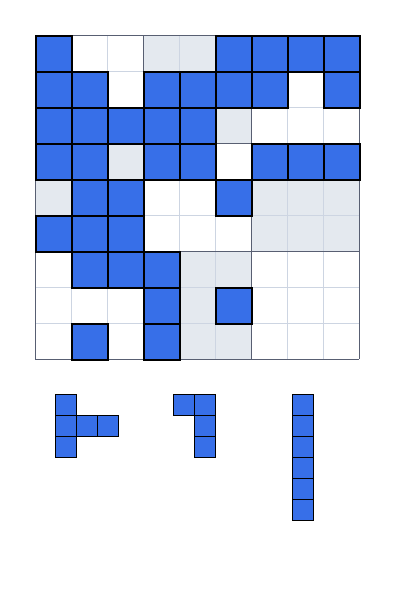

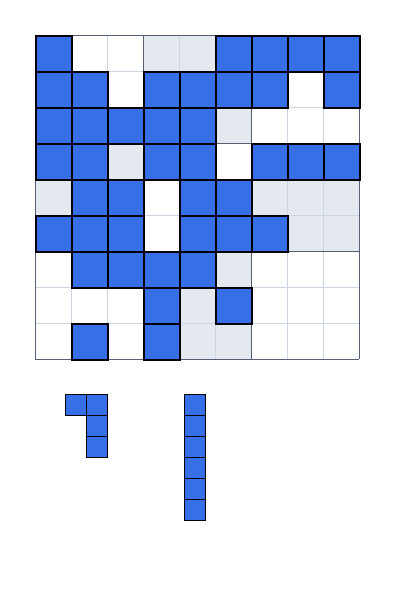

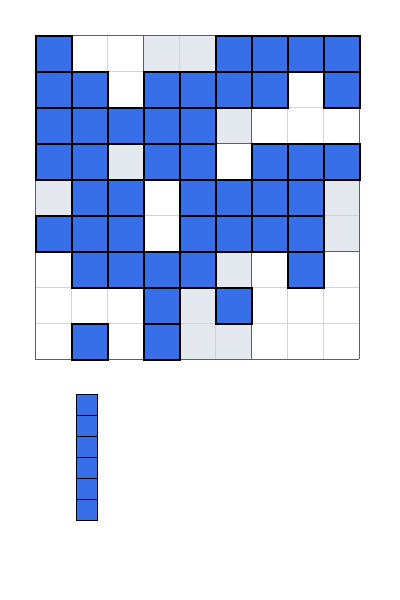

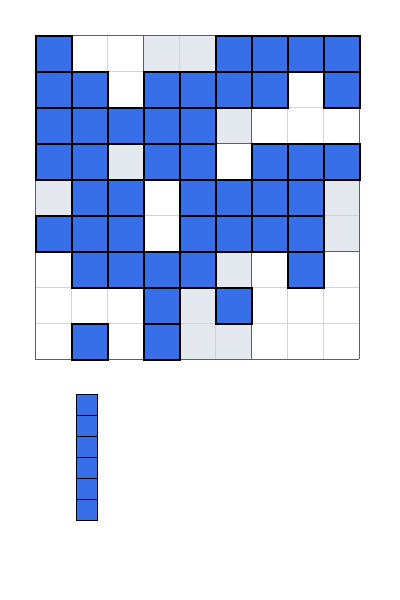

Total reward: 334


In [ ]:
# Plays a greedy game with the agent
play_game_with(agent)

In [ ]:
Version 4

**Version 4**

-Copied version 3
-Mia experimenting with reward function


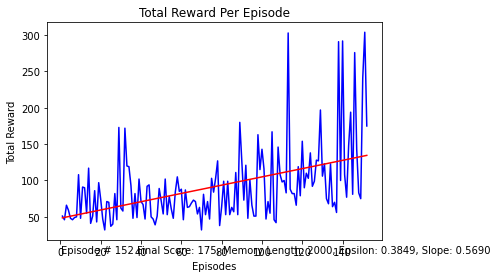

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import Sequential, Model
from tensorflow.python.keras.layers import Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import numpy as np
import copy
import pylab as plt
from google.colab import output
import os.path
from datetime import datetime

class DQNAgent_with_ER_and_FTN_V3:
  def __init__(self, verbose=2, state_includes_pieces=False, use_toy_env=False, clone=None):
    # Parameters
    self.epsilon = 0.99
    self.epsilon_decay = .99
    self.epsilon_min = .01
    self.alpha = 0.15
    self.gamma = 1
    self.inverse_gamma = 1
    self.d_min = 1000
    self.d_max = 2000
    self.c = 20
    self.no_replays = 10

    #Adjustable Parameters
    self.verbose=verbose
    self.start_time = datetime.now()
    self.state_includes_pieces = state_includes_pieces;

    self.env = bdtoy.SudokuTetrisGame() if use_toy_env else bd.SudokuTetrisGame()
    
    self.input_shape = (self.state_action_representation(self.env).size,)
    
    ## Algorithm: Deep Q-Learning with Experience Replay and Fixed Target Network
    ## Initialise replay memory 𝐷 to capacity 𝑁
    self.d = deque(maxlen = self.d_max)
    ## Initialise action-value network 𝑞1 with random weights 𝜽1
    self.q1 = self._build_DNN()
    ## Initialise target action-value network 𝑞2 with weights 𝜽2 = 𝜽1
    self.q2 = tf.keras.models.clone_model(self.q1)

    if clone != None:
      self.start_time = clone.start_time
      self.d = clone.d
      self.q1 = clone.q1
      self.q2 = clone.q2

  def train(self, episodes=1):
    scores, eps = [], []
    step_count = 1
    ## For episode = 1, 𝑀 do
    for e in range(episodes):
      ## Initialise initial state 𝑆1
      self.env.reset()
      state = copy.deepcopy(self.env)
      ## For 𝑡 = 1, 𝑇 do
      done = False
      total_reward = 0
      while not done:
        ## With probability 𝜖 select random action 𝐴𝑡
        action = self.get_epsilon_greedy_action()
        ## Execute action 𝐴𝑡 and observe reward 𝑅𝑡, next state 𝑆𝑡+1
        _, reward, done, _ = self.env.step(action)
        culm_reward=copy.deepcopy(reward)
        if reward<5:
          reward=-1
        total_reward += culm_reward
        ## Store transition (𝑆𝑡, 𝐴𝑡, 𝑅𝑡, 𝑆𝑡+1) in 𝐷
        next_state = copy.deepcopy(self.env)
        self.d.append((state, action, reward, next_state))

        ## Sample random minibatch of transitions (𝑆𝑗, 𝐴𝑗, 𝑅𝑗, 𝑆𝑗+1) from 𝐷
        if len(self.d) > self.d_min:
          self.replay(self.no_replays)
          
        ## Every 𝐶 steps update 𝜽2 = 𝜽1
        if step_count % self.c == 0:
          self.q2 = tf.keras.models.clone_model(self.q1)
        # update variables
        step_count += 1
        state = next_state

        
        if done:
          ## Decay epsilon after each episode (not in original algorithm) (only if memory full)
          if self.epsilon > self.epsilon_min and len(self.d) > self.d_min:
            self.epsilon *= self.epsilon_decay

          # every episode, plot the play time
          eps.append(e+1)
          scores.append(total_reward)
          
          self.plot_print_and_write_to_file(eps, scores)
          
      ## End For
    ## End For

  def plot_print_and_write_to_file(self, eps, scores):
    # Plot
    x, y =  np.array(eps), np.array(scores)
    
    plt.plot(x, y, 'b')
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color='red')
    plt.title('Total Reward Per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')

    # Print
    if self.verbose >= 1:
      plt_text = "Episode # {} Final Score: {}, Memory Length: {}, Epsilon: {:.4f}, Slope: {:.4f}".format(eps[-1], scores[-1], len(self.d), self.epsilon, m)
      plt.text(.5, .05, plt_text)

    # Write graph to file "DQN_V3_output{datetime}.png"
    current_time = self.start_time.strftime("%a_%d%B%Y-%H:%M:%S")
    png_fname = "DQN_V3_output-" + current_time + ".png"
    plt.savefig('/content/{}'.format(png_fname))

    # Save data to a csv-formatted file
    csv_fname = "'DQN_V3_data-" + current_time + ".csv"
    if not os.path.exists(csv_fname):
      with open(csv_fname, 'w+') as f:
        title = "episode_no,final_score,memory_length,epsilon,slope\n"
        f.write(title)

    with open(csv_fname, 'a') as f:
      data = "{},{},{},{},{}\n".format(eps[-1], scores[-1], len(self.d), self.epsilon, m)
      f.write(data)

    # # Save q1 and q2 to files (Use if Pickle doesn't work, otherwise delete)
    # q1_model_fname = "'DQN_V3_q1_model-" + current_time
    # tf.keras.models.save_model(self.q1, q1_model_fname, overwrite=True)
    # q2_model_fname = "'DQN_V3_q2_model-" + current_time
    # tf.keras.models.save_model(self.q1, q2_model_fname, overwrite=True)

    if self.verbose == 2:
      # Show plot
      output.clear()
      plt.show()

  def get_greedy_action(self):
    best_action = None
    best_value = - float('inf')
    for a in self.env.get_available_actions():
      env_copy = copy.deepcopy(self.env)
      _, reward, done, _ = env_copy.step(a)
      if not done:
        v = reward + self.q1.predict(self.state_action_representation(env_copy))[0][0]
      else:
        v = reward
      if v > best_value:
        best_action = a
        best_value = v
    action = best_action
    return action

  def get_greedy_action2(self):
    done_arr, reward_arr, state_arr = [], [], []
    action_arr = self.env.get_available_actions()
    for a in action_arr:
      env_copy = copy.deepcopy(self.env)
      _, reward, done, _ = env_copy.step(a)
      done_arr.append(0 if done else 1)
      reward_arr.append(reward)
      state_arr.append(self.state_action_representation(env_copy))
    done_arr, reward_arr, state_arr = np.array(done_arr), np.array(reward_arr), np.array(state_arr)
    # Run predict on a batch of all possible states for action
    next_value_arr = np.reshape(self.q1.predict(np.array(state_arr)), reward_arr.shape)
    # v = r + (v_next_state if done else 0)
    v_arr = np.add(np.array(reward_arr), np.multiply(np.array(done_arr), next_value_arr))
    # Choose best action from v then find corresponding action
    action = action_arr[np.argmax(v_arr)]
    return action
    
  def get_epsilon_greedy_action(self):
    # Get Random Action
    if self.epsilon > random.random():
      return self.env.sample_action()
    ## Greedy Action: With probability 1 − 𝜖
    else:
      # return self.get_greedy_action2()
      return self.get_greedy_action()

  def replay(self, no_replays):
      for i in range(no_replays):
        state, action, reward, next_state = random.choice(self.d)
        yj = 0
        ## if 𝑆𝑗+1 is terminal: Set 𝑦𝑗 = 𝑅𝑗 + 0
        if next_state.check_if_done():
          yj = reward        
        ## otherwise: Set 𝑦𝑗 = 𝑅𝑗 + max 𝑎′𝑞2(𝑆𝑗+1, 𝑎′, 𝜽2)
        else:
          # prediction = self.predict_q2(next_state).flatten()
          # best_action = np.nanargmax(prediction)
          # best_value = prediction[best_action]
          # yj[action] = self.inverse_gamma*reward + self.gamma*best_value
          yj = reward + self.predict_q2(next_state)[0][0]
        ## Perform gradient descent step ∇𝜽1𝐿𝛿(𝑦𝑗, 𝑞1(𝑆𝑗, 𝐴𝑗, 𝜽1))
        self.q1.fit(self.state_action_representation(state), np.array([yj]).reshape(1, -1), epochs=1, verbose=False)

  def _build_DNN(self):
    model = Sequential()
    model.add(Input(shape=self.input_shape))
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='linear', kernel_initializer='he_uniform'))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=Adam(lr=self.alpha))
    return model

  def predict_q1(self, state) :
    DNN_input = self.state_action_representation(state)
    value_prediction = self.q1.predict(DNN_input)
    return value_prediction

  def predict_q2(self, state):
    DNN_input = self.state_action_representation(state)
    value_prediction = self.q2.predict(DNN_input)
    return value_prediction

  def state_action_representation(self, state):
    # Get state representation
    board_rep = [1 if square else 0 for square in state.board.flatten()]
    # Change parameter to include the pieces in the state representation (Optional)
    if self.state_includes_pieces:
      pieces_rep = [1 if bd.PIECES[x] in state.current_pieces else 0 for x in range(len(bd.PIECES))]
      board_rep = board_rep + pieces_rep

    return np.array(board_rep).reshape(-1, len(board_rep))

agent = DQNAgent_with_ER_and_FTN_V3()
agent.train(10000)

In [ ]:
agent2 = DQNAgent_with_ER_and_FTN_V3(clone=agent)
agent2.train(10000)